# Lab N: Dimensional Reduction for Classificaiton of Astronomical Images
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22/)
#### [Prof. Ashley Villar](http://ashleyvillar.com/menu/about/) (PSU)

## Overview 
In this notebook, you will work through an example of incorporating dimensionality reduction techniques into a pipeline for classifying images of galaxies.  You will compare the behavior of two algorithms: 
- principle component analysis (PCA) and
- t-distributed stochastic neighbor embedding (t-sne). 

This lab builds on previous lessons that introduced of logistic regession, support vector machines (SVMs), methods for evaluating the performance of an ML algorithm, and techniques for training ML models like under sampling.  Feel free to refer back to those lessons as needed.  

[//]: # "TODO: Add links above once have them."

## Installation & Setup
The next two code cells merely install and import packages that will be used below.  
(Note that the installation will likely take some time to run the first time.  And it's ok if you get lots of messages beginning "Requirment already satisfied".  Similarly, it's ok if you get a couple of warnings about environment variables not being set after the cell importing packages.)

In [1]:
# Install statement(s)
!pip install astroNN
!pip install opentsne

In [2]:
# Import statement(s)
from astroNN.datasets import load_galaxy10               # Provides example datasets to be analyzed
from astroNN.datasets.galaxy10 import galaxy10cls_lookup # Provides labels for training/evaluating models

import numpy as np                                  # Common python package for array maniuplations
import matplotlib.pyplot as plt                     # Common python package for plotting

from sklearn.linear_model import LogisticRegression # Implements Logistic regression
from sklearn import svm                             # Implements SVM 
from sklearn.decomposition import PCA               # Implements PCA
#from sklearn.manifold import TSNE                   # Implements t-sne.  Replaced with openTSNE

# Tools for easily training and evaluating ML model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


Next, we'll retreive an array of images (which will be our inputs) and an array of integer labels (which we will use to train/evaluate our models).  Again, this may take some time the first time you run it, as it will download data from the internet.  But it should return within ~10 seconds on subsequent calls.

In [3]:
# Load the RGB images and labels from astroNN
images_4d, labels_all = load_galaxy10()

Galaxy10.h5:  99%|█████████▉| 209M/210M [00:06<00:00, 33.3MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:08, 25.7MB/s]                           


## Part 1: Exploratory Data Analysis & Preprocessing

Before building a complex model, it's always a good idea to do some basic exploratory data analysis.  First, checking the variables types and array shapes can help reduce bugs.  Second, the intuition that you build by looking at some examples is often helpful in deciding what forms of preprocessing are likely to generate useful features and choose appropriate strategies for training a machine learning model. 

### Exploring the data
First, let's investigate the data stored in images and labels.  
1a.  Inspect the output of the following cells to answer the following questions:
- What is the *shape* of each individual galaxy image?  
- What is the *data type* of the `labels` variable? 
- If pass one of the `labels` to the `galaxy10cls_lookup()` function, what is returned?  


In [4]:
images_4d.shape        # Images, x coordinate, y coordinate, color

(21785, 69, 69, 3)

In [5]:
labels_all.shape

(21785,)

In [6]:
labels_all[0], type(labels_all[0])

(2, numpy.uint8)

In [7]:
 galaxy10cls_lookup(labels_all[0])

'Smooth, in-between round'

The next code block demonstrates how to plot a colored image of a single galaxy and how to lookup its galaxy type based on its numerical label. 

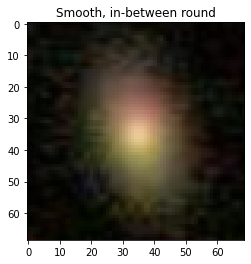

In [8]:
img_id = 0
plt.imshow(images_4d[img_id]);
plt.title(galaxy10cls_lookup(labels_all[img_id]));

1b. Modify **img_id** in the cell above and rerun the cell to view several images for several galaxies.

### Choosing classes to include in model

1c. Inspect the histogram of the class types. How many classes are there in total? Are the classes *balanced*?

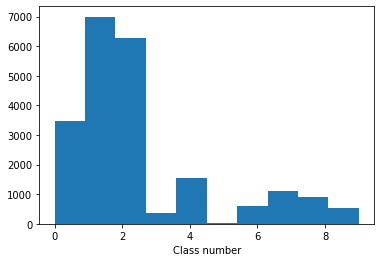

In [9]:
plt.hist(labels_all);
plt.xlabel('Class number');

1d. Modify `label_id_to_find` in the cell below to inspect an image for each of the unique class of galaxies and its an associated title. 

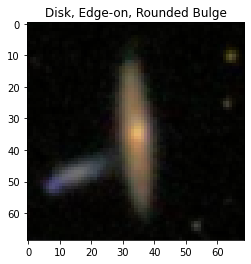

In [10]:
label_id_to_find = 2
first_img_with_label = labels_all[np.where(labels_all==label_id_to_find)][0]
plt.imshow(images_4d[first_img_with_label]);
plt.title(galaxy10cls_lookup(labels_all[first_img_with_label]));

1e. If you were to start by building a model to predict the  classifications of the most common cases, which three values of label would you want to include in your training and testing data sets?

1f.  Which pair of galaxy classifications do you anticipate will be hardest for a machine learning algorithm to accurately distinguish?

### Preprocessing
While storing each image as a 3-d array is useful for visualizing them, many ML packages want their features as a simple 1-d array.  Therefore, we'll flatten the data into a 2-d array, with the first index being the image id and the second index running over all (x,y) coordinates and color values.  

We'll also filter the full dataset to pick only a subset of images (and their corresponding labels) to use for the subsequent analysis.

In [11]:
idx_images_to_keep = np.where(labels_all<=2)
labels = labels_all[idx_images_to_keep]
images_flat = images_4d.reshape(len(images_4d),-1)   # Flatten to a 2_d array
images_flat = images_flat[idx_images_to_keep]
images_flat.shape, labels.shape

((16750, 14283), (16750,))

1f.  Approximately what fraction of the dataset was retained?

# Part 2: Logistic Regression as a Baseline Model
First, we need to split the dataset into a training dataset (e.g., 67%) and test dataset (e.g., 33%) using the `train_test_split` function.  Verify the output sizes are as expected.

In [12]:
frac_in_testset = 0.33
X_train, X_test, y_train, y_test = train_test_split(images_flat, labels, test_size=frac_in_testset)
len(X_train)/len(images_flat), len(X_test)/len(images_flat)

(0.6699701492537313, 0.33002985074626867)

Next we'll use the the `LogisticRegression` function to train a generalized linear model to prediction the galaxy class directly from its flattened image.  (By specifying `class_weight` to be `balanced`, we instruct the algorithm to set the weights for each galaxy image inversely proportional to classfrequency of its label in the input dataset.)  This simple model will become our baseline for comparing the performance of more sophisticated models. 

In [13]:
classifier_lr = LogisticRegression(random_state=0, class_weight='balanced', solver='sag', max_iter=50).fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


2a.  How how long did it take to train the logistics regression model on the training dataset?  

[//]: # "TODO: How do we extract the runtime from the Jupyter notebook on our server? (In collab, the run time appears in small print below the checkmark to the left of the cell once it's completed running.)"

Did the model fitting procedure converge within the number of itterations alloted?  



Next, we'll test our model by asking it to predict the labels for the *test set*.  To assess the performance, we'll compute the accuracy score (i.e., how often the predicted label is correct) and inspect the plot of the confusion matrix for the *test* set below. 

In [14]:
y_pred_lr = classifier_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test,y_pred_lr)
print("Accuracy: ",accuracy_lr)

Accuracy:  0.49403039073806077


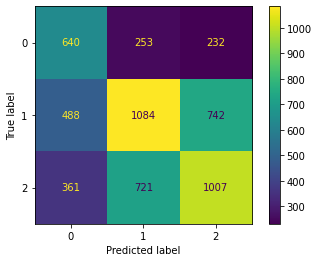

In [15]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot();

2b.  What is the two most common mistakes by the logistic regression classifier?  How does that compare to your prediction from above?

Since we're considering three classes, we can't make a simple 2-d plot of the Receiver operating characteristic (ROC) curve, like we could for binary classification.  However, we can still calculate an the area under the curve (AUC) for the ROC curve for each galaxy type and then taken an average of the AUC scores.  (The optional parameter `multi_class` specifies whether we want to compare each pair of classifications (i.e., "one-vs-one") or  "one-verus-rest") and `average` specifies a weighting scheme for the average.)

In [16]:
y_pred_prob_lr = classifier_lr.predict_proba(X_test)   
macro_roc_auc_ovo_lr = roc_auc_score(y_test, y_pred_prob_lr, multi_class="ovo", average="macro")
print("AUC (one-vs-one): ",macro_roc_auc_ovo_lr)

AUC (one-vs-one):  0.6868955119267565


Once we've trained other classifiers below, we'll look back to compare their accuracy and AUC scores to those of logistic regression.

# Part 3: SVM Baseline

Previously we used a linear model due to the significant computational time required to fit a nonlinear classification model to the large volume of image data.  Next, we'll use a [*support vector machine*](https://en.wikipedia.org/wiki/Support-vector_machine) with a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).

In principle, we could apply SVM to the exact same data set.However, the computational cost would be prohibitive.  (Therefore, the code to do that below is intentionally commented out.) 

In [17]:
#classifier_svm = svm.SVC(probability=True).fit(X_train, y_train)
#classifier_svm.predict(X_train)

In order to make things computationally feasible, we could apply the simplest possible form of dimensional reduction, selecting a subset of the input features.  For example, we could keep every nth pixel value.

In [18]:
keep_every_nth_pixel = 290      # 290 was chosen, so that we'd end up with 50 values from each low-res image
X_train_lowres = X_train[:,::keep_every_nth_pixel]
X_test_lowres = X_test[:,::keep_every_nth_pixel]
X_train_lowres.shape, X_test_lowres.shape

((11222, 50), (5528, 50))

3a.  How many pixels are being retained in each image?

We can train an SVM classifier using the `svm.SVC` function on the low-resolution version of the training set.

In [19]:
classifier_lowres = svm.SVC(probability=True, class_weight='balanced').fit(X_train_lowres, y_train)
#classifier_lowres.predict(X_train_lowres)


And calculate the overall accuracy of this model. 

In [20]:
y_pred_lowres = classifier_lowres.predict(X_test_lowres)
accuracy_lowres = accuracy_score(y_test,y_pred_lowres)
print("Accuracy: ",accuracy_lowres)

Accuracy:  0.6756512301013025


3b.  How does the accuracy of the SVM on the low-resolution dataset compare to the accuracy of logistic regression on the full-resolution dataset?

Next, we'll compute the AUC score using the baseline SVM model.

In [21]:
y_pred_prob_lowres = classifier_lowres.predict_proba(X_test_lowres)
macro_roc_auc_ovo_lowres = roc_auc_score(y_test, y_pred_prob_lowres, multi_class="ovo", average="macro")
print("AUC: ",macro_roc_auc_ovo_lowres)

AUC:  0.8623689765547115


3c. How does the AUC score for the low-resolution SVM model compare to the baseline logistic regression model?


Next, we'll inspect the confusion matrix.

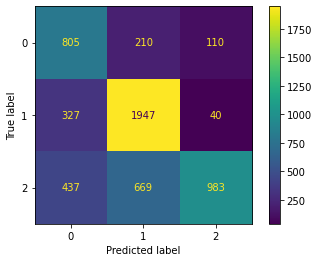

In [22]:
y_pred_lowres = classifier_lowres.predict(X_test_lowres)
cm_lowres = confusion_matrix(y_test, y_pred_lowres)
disp_lowres = ConfusionMatrixDisplay(confusion_matrix=cm_lowres)
disp_lowres.plot();

3d. How does the confusion matrix for the *test* set using SVM on the low-resolution images compare to the confusion matrix for the *test* set using logistic regression on the full-resolution data?

# Part 4: SVM with PCA

In Part 3, we used SVM on low-resolution images.  Our astronomical intuition is that the classificaiton would be easier if we could preserve more of the information in the high-resolution images.  [Principal Componets Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) provides an efficient means of performing dimensional reduction.  

4a.  What do you anticipate the first few principal components might look like?  Once you've made your prediction, run the cell below to plot the first few principal components. (Remember that we need to reshaping them back into images for visualization purposes.) them.

In [23]:
num_pca_components = 50
pca = PCA(n_components=num_pca_components)
pca.fit(X_train)

PCA(n_components=50)

First, we will apply PCA to reduce the dimesionality of our images using the `PCA` function.

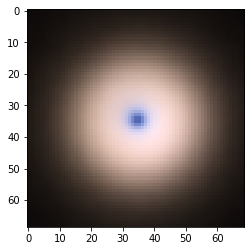

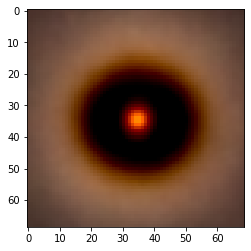

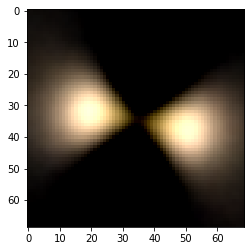

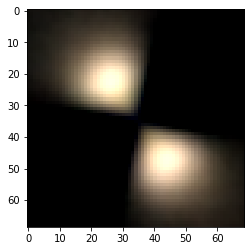

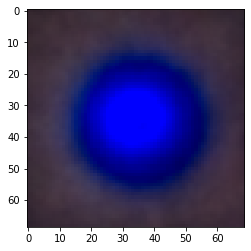

In [24]:
plt.imshow(num_pca_components * pca.components_[0,:].clip(0,1/num_pca_components).reshape(69,69,3));
plt.show();
plt.imshow(num_pca_components * pca.components_[1,:].clip(0,1/num_pca_components).reshape(69,69,3));
plt.show();
plt.imshow(num_pca_components * pca.components_[2,:].clip(0,1/num_pca_components).reshape(69,69,3));
plt.show();
plt.imshow(num_pca_components * pca.components_[3,:].clip(0,1/num_pca_components).reshape(69,69,3));
plt.show();
plt.imshow(num_pca_components * pca.components_[4,:].clip(0,1/num_pca_components).reshape(69,69,3));
plt.show();

4b.  How do the actual principal components compare to your predictions?  Try to qualitatively explain what each principal component captures.  

4c.  Roughly what fraction of the variance in the images might you guess could be explained with the first few principal components?  

We can print the fraction of the variance explained by each of the PCA components.  

In [25]:
print(pca.explained_variance_ratio_)

[0.47011448 0.06240416 0.05130099 0.04785585 0.03169002 0.01870388
 0.01660214 0.00994251 0.00966113 0.00881098 0.00843167 0.00774865
 0.0072031  0.00629056 0.00596832 0.00575488 0.0053451  0.00511188
 0.00423242 0.00395868 0.00368205 0.00328823 0.00320965 0.0030732
 0.00289268 0.00285658 0.00279456 0.00263698 0.00255316 0.00249447
 0.0024242  0.00234536 0.00213476 0.00208952 0.0020393  0.00202719
 0.00199065 0.00193662 0.00181591 0.00166379 0.00165332 0.00157264
 0.00155967 0.00153708 0.00149165 0.00148718 0.00142882 0.00138318
 0.00133145 0.0012738 ]


or plot the cumulative fraction of the variance explained by the first n PCA components

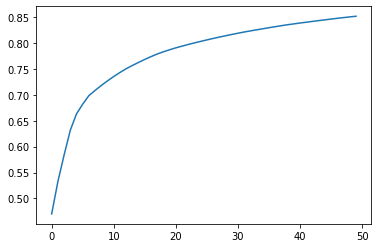

In [26]:
plt.plot(pca.explained_variance_ratio_.cumsum());

4d.  How did you guess compare to the actual fraction of variance explained?

Next, let us project the images onto the principal components.  
Then we'll plot the first two PCA scores which can become low-dimensional features and color codethe points according to the galaxy classification. 

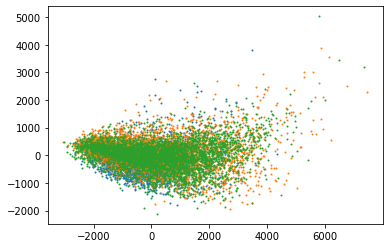

In [27]:
X_train_PCA = pca.transform(X_train)

for i in np.unique(y_train):
  index_images_with_label = np.where(y_train==i)
  plt.plot(X_train_PCA[index_images_with_label[0],0],X_train_PCA[index_images_with_label[0],1],'.',markersize=2)


4e.  Do you see natural clustering?

Now, we'll train an SVM classifier using the `svm.SVC` function on the training set of PCA scores.

In [28]:
clf_pca = svm.SVC(probability=True, class_weight='balanced').fit(X_train_PCA, y_train)
#clf_pca.predict(X_train_PCA)

As before, let's compute the accuracy score and AUC score for the SVM based on the PCA scores.

In [29]:
X_test_PCA = pca.transform(X_test)
y_pred_pca = clf_pca.predict(X_test_PCA)
accuracy_pca = accuracy_score(y_test,y_pred_pca)
print("Accuracy: ",accuracy_pca)

Accuracy:  0.7908827785817656


In [30]:
y_pred_prob_pca = clf_pca.predict_proba(X_test_PCA)
macro_roc_auc_ovo_pca = roc_auc_score(y_test, y_pred_prob_pca, multi_class="ovo", average="macro")
print("AUC: ",macro_roc_auc_ovo_pca)

AUC:  0.9239194679859049


4f. How do the accuracy and AUC scores compare to that of the SVM based on low-res versions of the galaxy images?


Now, we'll plot a confusion matrix for the *test* set using the SVM trained on the PCA scores. 

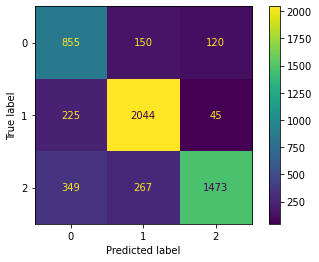

In [31]:
cm_pca = confusion_matrix(y_test, y_pred_pca)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca)
disp_pca.plot();

4g.  How does the confusion matrix for the SVM using PCA scores as features compare to the confusion matrix for the SVM trained on low-res galaxy images?

4h. How does the performance change if you increase or reduce the number of PCA scores used as features to the SVM?

# Part 5: Classification with t-sne

Finally, we will explore classification of the same galaxy images, but using the outputs of t-sne as features to the SVM. Note that this is *not* typically used for classifcation tasks, and we will see why.


First, we'll reduce the dimensionality of the PCA features.
For this, we will use the `TSNE` function from the `openTSNE` module. Note that `sklearn` also has a version of `tsne`; however, the `openTSNE` version will be much faster for our problem.
TSNE does not scale well with dimensionality.  Therefore, it is typically very helpful to begin in a lower dimensional space.  For example, we could use the PCA scores from Part 4 as inputs to t-sne.
It can also be useful to fit tsne to a subset of the fully dataset for visualization purposes.

In [32]:
from openTSNE import TSNE

tsne_200 = TSNE(n_components=2, perplexity=200)

X_train_tsne_200 = tsne_200.fit(X_train_PCA)

Let's visualize the reduced latent space from t-sne using a scatter plot and coloring each point by the galaxy labels.

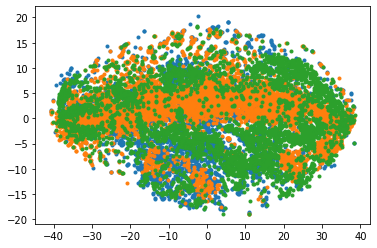

In [33]:
for i in np.unique(y_train):
  index_images_with_label = np.where(y_train==i)
  plt.plot(X_train_tsne_200[index_images_with_label[0],0],X_train_tsne_200[index_images_with_label[0],1],'.')
  plt.plot('t-sne component 1')
  plt.plot('t-sne component 2')

5a.  How do the first two t-sne features compare to the first two PCA scores?  Do you expect that these will be useful for classifying galaxies with a SVM?  

Try rerunning t-sne.  Since it's a stochastic algorithm, we expect the specific results might change from one run to the next.  Do you expect the run-to-run variations will affect their utility for classification?

Next, try rerunning t-sne, but using a few different values for the perplexity.

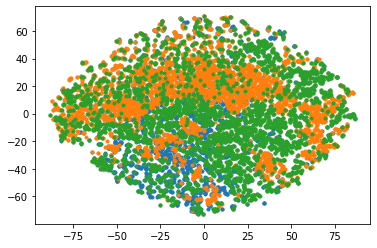

In [34]:
tsne_alt = TSNE(n_components=2, perplexity=5)
X_train_tsne_alt = tsne_alt.fit(X_train_PCA)

for i in np.unique(y_train):
  index_images_with_label = np.where(y_train==i)
  plt.plot(X_train_tsne_alt[index_images_with_label[0],0],X_train_tsne_alt[index_images_with_label[0],1],'.')
  plt.plot('t-sne component 1')
  plt.plot('t-sne component 2')

5b. How does the choice of the perplexity parameter impact the latent space?

Now, we can train an SVM classifier with the outputs of the t-sne algorithm as the features for the training set.

In [38]:
classifier_tsne = svm.SVC(probability=True, class_weight='balanced').fit(X_train_tsne_200, y_train)

As before, we can calculate the overall accuracy of this model and its AUC score. 

In [41]:
X_test_tsne_200 = X_train_tsne_200.transform(X_test_PCA)
y_pred_tsne_200 = classifier_tsne.predict(X_test_tsne_200)
accuracy_tsne_200 = accuracy_score(y_test,y_pred_tsne_200)
print("Accuracy: ", accuracy_tsne_200)

y_pred_prob_tsne_200 = classifier_tsne.predict_proba(X_test_tsne_200)
macro_roc_auc_ovo_tsne_200 = roc_auc_score(y_test, y_pred_prob_tsne_200, multi_class="ovo", average="macro")
print("AUC: ", macro_roc_auc_ovo_tsne_200)

Accuracy:  0.5788712011577424
AUC:  0.7266073298509547


5c.  How do the accuracy and AUC scores compare to those of our previous methods?  Why do you think this is (think back to your visualization of the latent space)?

Similarly, we can plot the confusion matrix for the test set based on an SVM with the t-sne outputs as its input features.



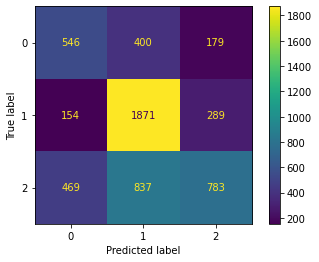

In [42]:
cm_tsne_200 = confusion_matrix(y_test, y_pred_tsne_200)
disp_tsne_200 = ConfusionMatrixDisplay(confusion_matrix=cm_tsne_200)
disp_tsne_200.plot();

5d.  How does this confusion_matrix compare to the confusion matrix using the other algorithms and features?  

## To learn more
- [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)
- [Dimensionality Reduction for Data Visualization](https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29)
- [Explore U-Map](https://grantcuster.github.io/umap-explorer/)
